In [1]:
import os
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numba import jit
import pygmo as pg

In [2]:
funcs = {"sphere": 0, "schwefel": 1, "rosenbrock": 2, "rastrigin": 3, "griewank": 4, "ackley": 5}
funcs_dispname = {"sphere": "F1 : Shifted Sphere Function", 
                  "schwefel": "F2 : Schwefel’s Problem 2.21",
                  "rosenbrock": "F3 : Shifted Rosenbrock’s Function",
                  "rastrigin": "F4 : Shifted Rastrigin’s Function",
                  "griewank": "F5 : Shifted Griewank’s Function",
                  "ackley": "F6 : Shifted Ackley’s Function"}

In [3]:
def read_values(func):
    val_path = os.path.join('../data/', func + '.csv')
    bias_path = '../data/f_bias.csv'
    ss_path = '../data/search_space.csv'
    
    func_df = pd.read_csv(val_path)
    bias_df = pd.read_csv(bias_path)
    searchspace_df = pd.read_csv(ss_path)

    funcval = func_df.fvalue.values
    funcbias = bias_df.fvalue.values[funcs[func]]
    search_space = list(searchspace_df.iloc[funcs[func],])
    return funcval, funcbias, search_space

In [4]:
# function evaluation definitions

@jit(nopython=True)
def eval_fitness(x, dim):
    
    if func_name == "sphere":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z * z
        result = F + funcbias
    elif func_name == "schwefel":
        F = abs(x[0]- funcval[0])
        for i in range(1,dim - 1):
            z = x[i] - funcval[i]
            F = max(F, abs(z))
        result = F + funcbias
    elif func_name == "rosenbrock":
        F = 0
        y = np.empty(dim)
        for i in range(dim - 1):
            y[i] = x[i] - funcval[i] +1
        for i in range(dim-2):
            F += 100 * ((y[i]**2-y[i+1])**2) + (y[i]-1)**2
        result = F + funcbias
    elif func_name == "rastrigin":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z ** 2 - 10 * math.cos(2 * math.pi * z) + 10
        result = F + funcbias
        
    elif func_name == "griewank":
        F1 = 0
        F2 = 1
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F1 += z ** 2 / 4000
            F2 += math.cos(z / math.sqrt(i + 1))
        result = F1 - F2 + 1 + funcbias
    elif func_name == "ackley":
        Sum1 = 0
        Sum2 = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            Sum1 += z ** 2
            Sum2 += math.cos(2 * math.pi * z)
        result = -20 * math.exp(-0.2 * math.sqrt(Sum1 / dim)) - math.exp(Sum2 / dim) + 20 + math.e + funcbias
    else:
        result = 0
    
    return result

In [5]:
# Define UDP problem Class

class My_problem:
    def __init__(self, dim, bounds, glob_opt):
        self.lower_bound = bounds[0]
        self.upper_bound = bounds[1]
        self.dimension = dim
        self.fitness_per_eval = []
        self.glob_opt = glob_opt

    def fitness(self, x):
        result = eval_fitness(x, self.dimension)
        return [result]

    def get_bounds(self):
        x_min = self.lower_bound * np.ones(self.dimension)
        x_max = self.upper_bound * np.ones(self.dimension)
        return x_min, x_max

In [92]:
# function to run selected algorithm on defined problem

def solve_pb(dim, my_algo, bounds, optim, popsize):
    pop = None
    prob = pg.problem(My_problem(dim, bounds, optim))
    pop = pg.population(prob, popsize)

    my_algo.set_verbosity(100)

    t1 = time.time()
    pop = my_algo.evolve(pop)
    t2 = time.time()

    time_diff = t2-t1
    
    if my_algo.get_name().split(":")[0] == "PSO":
        extract_algo = my_algo.extract(pg.pso)
    elif my_algo.get_name().split(":")[0] == "GPSO":
        extract_algo = my_algo.extract(pg.pso_gen)
    elif my_algo.get_name().split(":")[0] == "DE":
        extract_algo = my_algo.extract(pg.de)
    elif my_algo.get_name().split(":")[0] == "saDE":
        extract_algo = my_algo.extract(pg.sade)
    elif my_algo.get_name().split(":")[0] == "sa-DE1220":
        extract_algo = my_algo.extract(pg.de1220)
    elif my_algo.get_name().split(":")[0] == "SGA":
        extract_algo = my_algo.extract(pg.sga)
    elif my_algo.get_name().split(":")[0] == "ABC":
        extract_algo = my_algo.extract(pg.bee_colony)
    elif my_algo.get_name().split(":")[0] == "xNES":
        extract_algo = my_algo.extract(pg.bee_colony)
    
    log = extract_algo.get_log()-funcbias
    curve = [x[2] for x in log]
    niter = log[-1][0]
    
    return pop, curve, niter, time_diff

In [7]:
# function to make print report of function solving

def print_solution(dimension, my_algo, pop_evolved, log, niter, duration):
    algorithm_name = my_algo.get_name()
    parameters = my_algo.get_extra_info()
    solution_x = pop_evolved.champion_x
    fitness = pop_evolved.champion_f[0]-funcbias
    n_evals = pop_evolved.problem.get_fevals()
    print('-'*60)
    print("Function: %s" % funcs_dispname[func_name])
    print("Problem dimension: %d" % dimension)
    print("Search Space : ", search_space)
    print("Global Optimum: %.2f" % funcbias)
    print('-'*60)
    print("Algorithm: %s" % algorithm_name)
    print("Parameters: \n%s" % parameters)
    print('-'*60)
    print("Fitness: %f" % fitness)
    print("Solution: ")
    with pd.option_context('display.max_rows',8):
        print(pd.DataFrame(solution_x, columns=['X']))
    print('-'*60)
    print("Nb of functions evaluations: %d" % n_evals)
    print("Stopping criterion: after %d iterations" % niter)
    print("computational time: %.3f seconds" % duration)

    plt.plot(log)
    plt.xlabel("iterations (x100)")
    plt.ylabel("fitness: f(x)-f(x*)")
    plt.show()

In [98]:
# function to choose: sphere, schwefel, rosenbrock, rastrigin, griewank, ackley
func_name = 'rosenbrock'
funcval, funcbias, search_space = read_values(func_name)

DIM = 500

In [99]:
# define algorithm
gen=5000
pop_size = 100

test_algo = []
test_algo.append(pg.pso(gen=gen))
test_algo.append(pg.pso_gen(gen=gen))
test_algo.append(pg.de(gen=gen))
test_algo.append(pg.sade(gen=gen))
test_algo.append(pg.de1220(gen=gen))
test_algo.append(pg.sga(gen=gen))
test_algo.append(pg.bee_colony(gen=gen))


In [100]:

popsizes = [100,250]
gens = [5000,10000]

for pop_size in popsizes:
    print("pop: %d" % pop_size)
    for gen in gens:
        print("\tgen: %d" % gen)
        for test in test_algo:  
            algo = pg.algorithm(test)
            t1 = time.time()
            pop_evolv, logs, nit, compute_time = solve_pb(dim=DIM, 
                                                      my_algo=algo, 
                                                      bounds=search_space, 
                                                      optim=funcbias, 
                                                      popsize=pop_size
                                                     )
            t2=time.time()
            fitness = pop_evolv.champion_f[0]-funcbias
            print("\t\t%s" % algo.get_name())
            print("\t\tfitness: %.1f" % fitness)
            print("\t\ttime: %.1f" % (t2-t1))

pop: 100
	gen: 5000
		PSO: Particle Swarm Optimization
		fitness: -724.4
		time: 10.5
		GPSO: Generational Particle Swarm Optimization
		fitness: -724.9
		time: 10.1
		DE: Differential Evolution
		fitness: -719.9
		time: 2.3
		saDE: Self-adaptive Differential Evolution
		fitness: -706.9
		time: 2.3
		sa-DE1220: Self-adaptive Differential Evolution 1220
		fitness: -743.2
		time: 3.1
		SGA: Genetic Algorithm
		fitness: -778.4
		time: 6.4
		ABC: Artificial Bee Colony
		fitness: -671.2
		time: 4.3
	gen: 10000
		PSO: Particle Swarm Optimization
		fitness: -725.8
		time: 11.1
		GPSO: Generational Particle Swarm Optimization
		fitness: -715.2
		time: 11.0
		DE: Differential Evolution
		fitness: -718.5
		time: 2.5
		saDE: Self-adaptive Differential Evolution
		fitness: -708.3
		time: 2.6
		sa-DE1220: Self-adaptive Differential Evolution 1220
		fitness: -735.9
		time: 3.5
		SGA: Genetic Algorithm
		fitness: -773.5
		time: 6.8
		ABC: Artificial Bee Colony
		fitness: -666.3
		time: 4.7
pop: 250
	

In [96]:
# ************** BEST FOR SCHWEFEL; DO NOT DELETE
pop_size = 200
gen = 25000

algo = pg.algorithm(pg.sga(gen=gen, 
                           cr=0.8, 
                           eta_c=5.0, # distribution index for sbx crossover
                           m=0.01, 
                           param_m=1, # distribution index (polynomial mutation), gaussian width (gaussian mutation) or inactive (uniform mutation)
                           param_s=10, # the number of best individuals to use in “truncated” selection or the size of the tournament in tournament selection.
                           crossover='sbx', # One of exponential, binomial, single or sbx
                           mutation='polynomial', # One of gaussian, polynomial or uniform
                           selection='truncated', # One of tournament, truncated.
                           seed=37
                          ))

print(algo.get_name())

SGA: Genetic Algorithm


In [ ]:
pop_size = 200
gen = 25000

algo = pg.algorithm(pg.sga(gen=gen, 
                           cr=0.8, 
                           eta_c=5.0, # distribution index for sbx crossover
                           m=0.01, 
                           param_m=1, # distribution index (polynomial mutation), gaussian width (gaussian mutation) or inactive (uniform mutation)
                           param_s=10, # the number of best individuals to use in “truncated” selection or the size of the tournament in tournament selection.
                           crossover='sbx', # One of exponential, binomial, single or sbx
                           mutation='polynomial', # One of gaussian, polynomial or uniform
                           selection='truncated', # One of tournament, truncated.
                           seed=37
                          ))

print(algo.get_name())

------------------------------------------------------------
Function: F2 : Schwefel’s Problem 2.21
Problem dimension: 500
Search Space :  [-100, 100]
Global Optimum: -450.00
------------------------------------------------------------
Algorithm: SGA: Genetic Algorithm
Parameters: 
	Number of generations: 25000
	Crossover:
		Type: sbx
		Probability: 0.8
		Distribution index: 5
	Mutation:
		Type: polynomial
		Probability: 0.01
		Distribution index: 1
	Selection:
		Type: truncated
		Truncation size: 10
	Seed: 37
	Verbosity: 100
------------------------------------------------------------
Fitness: 13.029537
Solution: 
             X
0   -33.815171
1    -3.290781
2   -67.667965
3   -99.773200
..         ...
496 -99.949187
497 -48.171532
498 -93.406884
499  20.477078

[500 rows x 1 columns]
------------------------------------------------------------
Nb of functions evaluations: 5000200
Stopping criterion: after 25351 iterations
computational time: 100.536 seconds


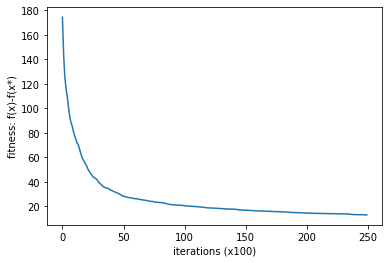

In [97]:
# run algorithm and print solution

pop_evolv, logs, nit, compute_time = solve_pb(dim=DIM, 
                                              my_algo=algo, 
                                              bounds=search_space, 
                                              optim=funcbias, 
                                              popsize=pop_size
                                             )

print_solution(dimension=DIM, 
               my_algo=algo, 
               pop_evolved=pop_evolv, 
               log=logs, 
               niter=nit, 
               duration=compute_time
              )

In [ ]:
# Grid search PSO
algo.set_seed(37)
def grid_pso():
    DIM = 50
    
    funcval, funcbias, search_space = read_values(func_name)

    omegas = [0.7,0.75]
    eta1 = [2,2.25]
    eta2 = [2,2.25]
    max_vel = [0.5,0.65]
    variant = [1,2,5]
    pops = [250]
    gen  = [2500]

    i=1
    fitold = 99999

    print("nb of variants to compute:",len(omegas)*len(eta1)*len(eta2)*len(max_vel)*len(variant)*len(pops)*len(gen))

    for omeg in omegas:
        for et1 in eta1:
            for et2 in eta2:
                for vel in max_vel:
                    for var in variant:
                        for pop in pops:
                            for g in gen:
                                algo = pg.algorithm(pg.pso(gen=g, omega=omeg, eta1=et1, eta2=et2, max_vel=vel, variant=var ))
                                pop_size = pop
                                pop_evolv, logs, nit, compute_time = solve_pb(dim=DIM, my_algo=algo, bounds=search_space, optim=funcbias, popsize=pop_size)
                                fit = print_search(dimension=DIM, my_algo=algo, pop_evolved=pop_evolv, log=logs, niter=nit, duration=compute_time)
                                if abs(fit) < abs(fitold):
                                    print("Variant %d: %f, %f, %f, %f, %d, %d, %d" % (i,omeg,et1,et2,vel,var,pop,g))
                                    print("\tfitness:",fit)
                                    print("\tduation:",compute_time)
                                    fitold = fit
                                print(i)
                                i += 1